In [ ]:
!pip install keras-segmentation

In [ ]:
# Before you continue, I am letting you know that my U-net architecture was taken from 
# https://keras.io/examples/vision/oxford_pets_image_segmentation/ which yielded me with the best results  compared to my own U-net models.
# I have made slight modifications in this U-net to provide me with a slightly better result.

In [ ]:
import numpy as np 
import pandas as pd 
import os
import sys
from sklearn.model_selection import train_test_split 
from matplotlib import pyplot as plt
from PIL import Image 
import random
import keras
import matplotlib.pyplot as plt
import glob
import cv2
import tensorflow as tf
from tensorflow import keras
import random
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, ZeroPadding2D, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from google.colab import drive
from google.colab import files
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LeakyReLU
from keras.layers import Dropout
from tensorflow.keras import utils
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
import imgaug as ia
import imgaug.augmenters as iaa
from keras_segmentation.models.unet import vgg_unet
#import segmentation as seg
from keras_segmentation.models.model_utils import get_segmentation_model
from IPython.display import display
import PIL
from PIL import ImageOps


drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Testing to ensure GPU is being utilized. This is being tested on Google colab
# This is a code snippet borrowed from google website to check if we have a GPU being used
# I noticed that whne using a GPU, my training has drastically increased, but google limits how much GPU you use
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('GPU device not found')
else:
  print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
# Creates 10 labels shown in the google dataset download webpage.
driving_classes = set(["road", "lane", "sky", "fence", "construction", "traffic sign", "car", "truck", "vegetation", "unknown"])

In [ ]:
# We know the original image dimensions and will resize it as needed to our liking
original_image_width = 1080
original_image_height = 720
original_image_size = (1080, 720)
ideal_image_size = (480,480)
batch_size = 4
channels = 3
ideal_width = 480
ideal_height = 480

In [ ]:
# I know there are 15 TrainSeq from 00-15. We will save this to a list which will be used to help create a full path to the image
dictionary_training={} # Stores our new variables
for i in range(0,10,1): # Will get the first 10 of the training sequence
  dictionary_training["string0{0}".format(i)]="TrainSeq0{0}".format(i)

for i in range(0,5,1): # Will get the last 5 of the training sequence
  dictionary_training["string1{0}".format(i)]="TrainSeq1{0}".format(i)

dictionary_training


{'string00': 'TrainSeq00',
 'string01': 'TrainSeq01',
 'string02': 'TrainSeq02',
 'string03': 'TrainSeq03',
 'string04': 'TrainSeq04',
 'string05': 'TrainSeq05',
 'string06': 'TrainSeq06',
 'string07': 'TrainSeq07',
 'string08': 'TrainSeq08',
 'string09': 'TrainSeq09',
 'string10': 'TrainSeq10',
 'string11': 'TrainSeq11',
 'string12': 'TrainSeq12',
 'string13': 'TrainSeq13',
 'string14': 'TrainSeq14'}

In [ ]:
# Makes sure that our dictionary that holds our own TrainSeq## works
get_first_value = list(dictionary_training.values())[0]
get_first_value

'TrainSeq00'

In [ ]:
# Checks to see if all the trainingseq## are printed in the correct format
for i in range (0,len(dictionary_training),1):
  display_values = list(dictionary_training.values())[i]
  print(display_values)


TrainSeq00
TrainSeq01
TrainSeq02
TrainSeq03
TrainSeq04
TrainSeq05
TrainSeq06
TrainSeq07
TrainSeq08
TrainSeq09
TrainSeq10
TrainSeq11
TrainSeq12
TrainSeq13
TrainSeq14


In [ ]:
# Get all file names for the images and the labels and saves it it in a list
save_train_directory = []
train_image_path = "/content/gdrive/My Drive/Colab Notebooks/CSCI 4931/PA 3/HighwayDriving1/Train/" 
train_label_path = "/content/gdrive/My Drive/Colab Notebooks/CSCI 4931/PA 3/HighwayDriving1/Train/" 
train_image_directories = os.listdir(train_image_path)
sort_train_files = sorted(train_image_directories)
print(sort_train_files)

for directory in sort_train_files:
  if(directory != '.DS_Store'):
    save_train_directory.append(directory)


['.DS_Store', 'TrainSeq00', 'TrainSeq01', 'TrainSeq02', 'TrainSeq03', 'TrainSeq04', 'TrainSeq05', 'TrainSeq06', 'TrainSeq07', 'TrainSeq08', 'TrainSeq09', 'TrainSeq10', 'TrainSeq11', 'TrainSeq12', 'TrainSeq13', 'TrainSeq14']


In [ ]:
# This will join the TrainSeq## Directory with images and labels so we can make a path to all the images.
image_join_path = "/image"
label_join_path = "/label"
save_modified_image_path = []
save_modified_label_path = []
for i in range(len(save_train_directory)):
  save_modified_image_path.append(save_train_directory[i] + image_join_path)
  save_modified_label_path.append(save_train_directory[i] + label_join_path)
print(save_modified_image_path)

['TrainSeq00/image', 'TrainSeq01/image', 'TrainSeq02/image', 'TrainSeq03/image', 'TrainSeq04/image', 'TrainSeq05/image', 'TrainSeq06/image', 'TrainSeq07/image', 'TrainSeq08/image', 'TrainSeq09/image', 'TrainSeq10/image', 'TrainSeq11/image', 'TrainSeq12/image', 'TrainSeq13/image', 'TrainSeq14/image']


In [ ]:
# Get all file names for the images and the labels and saves it it in a list
save_image_filenames = []
save_label_filenames = []
for i in range (0,len(dictionary_training),1):
  display_values = list(dictionary_training.values())[i]
  image_path = "/content/gdrive/My Drive/Colab Notebooks/CSCI 4931/PA 3/HighwayDriving/Train/" + display_values + "/image"
  label_path = "/content/gdrive/My Drive/Colab Notebooks/CSCI 4931/PA 3/HighwayDriving/Train/" + display_values + "/label"
  image_directories = os.listdir(image_path)
  label_directories = os.listdir(label_path)
  sort_image_files = sorted(image_directories)
  sort_label_files = sorted(label_directories)
# Print all the files and directory in the path.
  for image_file in sort_image_files:
    save_image_filenames.append(image_file)
    #print(image_file)
  for label_file in sort_label_files:
    save_label_filenames.append(label_file)

In [ ]:
# Make sure we have an even number of images and labels. 
print(len(save_image_filenames))
print(len(save_label_filenames))

900
900


In [ ]:
# Making sure the image file contains all image filenames and all save_labels is the labels
# Also ensures that the images and the labels matches with each other.
for i in range(0,120,1):
  print(save_image_filenames[i], "\t\t", save_label_filenames[i])


TrainSeq00_RGB_Image_0000.png 		 TrainSeq00_ColorLabel_0000.png
TrainSeq00_RGB_Image_0001.png 		 TrainSeq00_ColorLabel_0001.png
TrainSeq00_RGB_Image_0002.png 		 TrainSeq00_ColorLabel_0002.png
TrainSeq00_RGB_Image_0003.png 		 TrainSeq00_ColorLabel_0003.png
TrainSeq00_RGB_Image_0004.png 		 TrainSeq00_ColorLabel_0004.png
TrainSeq00_RGB_Image_0005.png 		 TrainSeq00_ColorLabel_0005.png
TrainSeq00_RGB_Image_0006.png 		 TrainSeq00_ColorLabel_0006.png
TrainSeq00_RGB_Image_0007.png 		 TrainSeq00_ColorLabel_0007.png
TrainSeq00_RGB_Image_0008.png 		 TrainSeq00_ColorLabel_0008.png
TrainSeq00_RGB_Image_0009.png 		 TrainSeq00_ColorLabel_0009.png
TrainSeq00_RGB_Image_0010.png 		 TrainSeq00_ColorLabel_0010.png
TrainSeq00_RGB_Image_0011.png 		 TrainSeq00_ColorLabel_0011.png
TrainSeq00_RGB_Image_0012.png 		 TrainSeq00_ColorLabel_0012.png
TrainSeq00_RGB_Image_0013.png 		 TrainSeq00_ColorLabel_0013.png
TrainSeq00_RGB_Image_0014.png 		 TrainSeq00_ColorLabel_0014.png
TrainSeq00_RGB_Image_0015.png 		 TrainSe

In [ ]:
# Makes sure that the os.path.join is outputting the proper path. 
print(os.path.join(save_modified_image_path[0],save_image_filenames[0]))

TrainSeq00/image/TrainSeq00_RGB_Image_0000.png


In [ ]:
# Makes sure that the path to the images every single training images is joined so when we open the image up later, we can open up 
# All images using a for loop. This allows us to turn it all into numpy arrays to be trained in our borrowed U-net model.
current_image_path = []
current_label_path = []
track = -1
for i in range(0,15,1):
  for j in range(0,60,1):
    track = track + 1
    #print(track)
    current_image_path.append(os.path.join(save_modified_image_path[i],save_image_filenames[track]))
    current_label_path.append(os.path.join(save_modified_label_path[i],save_label_filenames[track]))
    if(track == 899):
      break

print(len(current_image_path))
print(len(current_label_path))

900
900


In [ ]:
# Create a pandas dataframe for our image and labels filenames
files_dataframe = pd.DataFrame()
files_dataframe['images'] = current_image_path
files_dataframe['labels'] = current_label_path
files_dataframe

,images,labels
0,TrainSeq00/image/TrainSeq00_RGB_Image_0000.png,TrainSeq00/label/TrainSeq00_ColorLabel_0000.png
1,TrainSeq00/image/TrainSeq00_RGB_Image_0001.png,TrainSeq00/label/TrainSeq00_ColorLabel_0001.png
2,TrainSeq00/image/TrainSeq00_RGB_Image_0002.png,TrainSeq00/label/TrainSeq00_ColorLabel_0002.png
3,TrainSeq00/image/TrainSeq00_RGB_Image_0003.png,TrainSeq00/label/TrainSeq00_ColorLabel_0003.png
4,TrainSeq00/image/TrainSeq00_RGB_Image_0004.png,TrainSeq00/label/TrainSeq00_ColorLabel_0004.png
...,...,...
895,TrainSeq14/image/TrainSeq14_RGB_Image_0055.png,TrainSeq14/label/TrainSeq14_ColorLabel_0055.png
896,TrainSeq14/image/TrainSeq14_RGB_Image_0056.png,TrainSeq14/label/TrainSeq14_ColorLabel_0056.png
897,TrainSeq14/image/TrainSeq14_RGB_Image_0057.png,TrainSeq14/label/TrainSeq14_ColorLabel_0057.png
898,TrainSeq14/image/TrainSeq14_RGB_Image_0058.png,TrainSeq14/label/TrainSeq14_ColorLabel_0058.png


In [ ]:
# I have tried to train using training generators and zipping the image along with its labels together but it does not yield good results
# I have gotten better results just turning the images and the labels into numpy arrays and training the algorithm on it 

generate_all_images = ImageDataGenerator(validation_split=0.20, rescale = 1.0/255.0)
training_path = "/content/gdrive/My Drive/Colab Notebooks/CSCI 4931/PA 3/HighwayDriving/Train/"# + display_values 
# Below is the train generator which will be used for training the CNN using regular images
image_training_set = generate_all_images.flow_from_dataframe(dataframe=files_dataframe, directory=training_path, 
                                            x_col="images", y_col=None, class_mode=None,
                                            target_size=ideal_image_size, batch_size=4, validate_filenames=True
                                            , subset='training',color_mode='rgb',shuffle=False,seed=None)

# Below is the validation generator which will be used for validating the CNN using regular images 
image_validation_set = generate_all_images.flow_from_dataframe(dataframe=files_dataframe, directory=training_path, 
                                            x_col="images", y_col=None, class_mode=None,
                                            target_size=ideal_image_size, batch_size=4, validate_filenames=True
                                            , subset='validation',color_mode='rgb',shuffle=False,seed=None)

mask_training_set = generate_all_images.flow_from_dataframe(dataframe=files_dataframe, directory=training_path, 
                                            x_col="labels", y_col=None, class_mode=None,
                                            target_size=ideal_image_size, batch_size=4, validate_filenames=True
                                            , subset='training',color_mode='rgb',shuffle=False,seed=None)

mask_validation_set = generate_all_images.flow_from_dataframe(dataframe=files_dataframe, directory=training_path, 
                                            x_col="labels", y_col=None, class_mode=None,
                                            target_size=ideal_image_size, batch_size=4, validate_filenames=True
                                            , subset='validation',color_mode='rgb',shuffle=False,seed=None)

# We will zip the images and its corresponding labels together. This will be used to train our model.
training_generator = zip(image_training_set, mask_training_set)
validation_generator = zip(image_validation_set, mask_validation_set)

print(mask_training_set[0].shape)
print(image_training_set[0].shape)


print(len(image_training_set))
print(len(image_validation_set))

Found 720 validated image filenames.
Found 180 validated image filenames.
Found 720 validated image filenames.
Found 180 validated image filenames.
(4, 480, 480, 3)
(4, 480, 480, 3)
180
45


In [ ]:
# We will get the full path to every single image and every single label and store it in a list. 
# Everything is sorted so we know that every image and label in the list will correspond to each other.
get_full_image_path = []
get_full_label_path = []
training_path = "/content/gdrive/My Drive/Colab Notebooks/CSCI 4931/PA 3/HighwayDriving/Train/"
track = -1
for i in range(0,15,1):
  for j in range(0,60,1):
    track = track + 1
    #print(track)
    get_full_image_path.append(os.path.join(training_path,save_modified_image_path[i],save_image_filenames[track]))
    get_full_label_path.append(os.path.join(training_path,save_modified_label_path[i],save_label_filenames[track]))
    if(track == 899):
      break

# Checks to see if we get the same number of paths for every image and prints the full path of the image and label location.
print(len(get_full_image_path))
print(len(get_full_label_path))
print(get_full_image_path[0])
print(get_full_label_path[0])

900
900
/content/gdrive/My Drive/Colab Notebooks/CSCI 4931/PA 3/HighwayDriving/Train/TrainSeq00/image/TrainSeq00_RGB_Image_0000.png
/content/gdrive/My Drive/Colab Notebooks/CSCI 4931/PA 3/HighwayDriving/Train/TrainSeq00/label/TrainSeq00_ColorLabel_0000.png


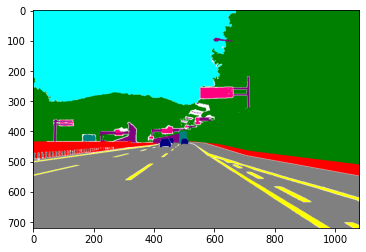

In [ ]:
# Printing the image full path to see if the image will actually open. It does which mean this is the correct path.
image = Image.open("/content/gdrive/My Drive/Colab Notebooks/CSCI 4931/PA 3/HighwayDriving/Train/TrainSeq00/label/" + save_label_filenames[0])

plt.imshow(image) # This shows the image without opening a new tab to view it in.
plt.show()

#resize = np.array(image).reshape(-1,240,240,3)

In [ ]:
# Open up all the images from the training set and turn them into a numpy array.
# After the image is converted, we will story that array in a list. This will be done for both the image and the label photos.

from PIL import Image
from numpy import asarray
image_array = []
label_array = []
for i in range(0,len(get_full_image_path),1):
  image = Image.open(get_full_image_path[i])
  resized_image = image.resize(ideal_image_size)
  numpy_image = asarray(resized_image)
  image_array.append(numpy_image)

  label = Image.open(get_full_label_path[i])
  resized_label = label.resize(ideal_image_size)
  numpy_label = asarray(resized_label)
  label_array.append(numpy_label)
  
# We will print to check and see if we have it as a numpy array, we have the same number of images and labels in the list and see if it is in the correct shape.
print(type(image_array[0]))
print(image_array[0].size)
print(image_array[0].shape)
print()
print(type(label_array[0]))
print(label_array[0].size)
print(label_array[0].shape)

<class 'numpy.ndarray'>
691200
(480, 480, 3)

<class 'numpy.ndarray'>
691200
(480, 480, 3)


In [ ]:
# We are reshaping the entire list to be (480,480,3)
image_array = np.array((image_array)).reshape(-1,ideal_width,ideal_height,3)
label_array = np.array((label_array)).reshape(-1,ideal_width,ideal_height,3)

# We make sure thaat we have 900 images in the format we want.
print(image_array.shape)
print(label_array.shape)

(900, 480, 480, 3)
(900, 480, 480, 3)


RGB


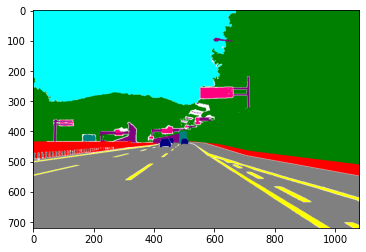

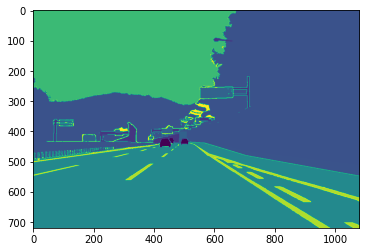

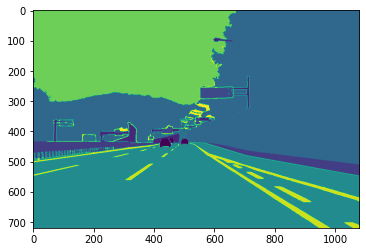

In [ ]:
# Test to see how the image looks in grayscale versus RGB.
# I have tested different ways to change the image to grayscale.
# The reason for this is because it takes less memory when the images are in grayscale versus RGB.
import matplotlib.image as mpimg
img = Image.open(get_full_label_path[0])
print(img.mode)
plt.imshow(img)
plt.show()
gray = img.convert('L')
gray.mode
plt.imshow(gray)
plt.show()

from skimage import io
gray1 = io.imread(get_full_label_path[0], as_gray=True)
plt.imshow(gray1)
plt.show()

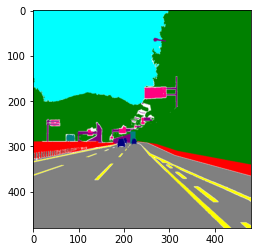

In [ ]:
# Testing to see if the label images are read into the list correctly without any issues when trying to redisplay it.
plt.imshow(label_array[0])
plt.show()

In [ ]:
# loop over the image, pixel by pixel
#print(label_array[0])
# This method takes up to much memory.
# I have attempted to label the 10 different colors pixel by pixel but it takes to much memory and I am unsure this is even teh correct way to do it
# In order to save memory, I will have to convert the images to grayscale and label it. This will save memory as it is limited.
"""
count = 0
c = 1
label_color = []
for frame in label_array:
  label_color1 = []
  for x in range(0,ideal_width): # Get the rows axis of the pixel
    label_color2 = []
    for y in range(0,ideal_height): # Gets the columns axis of the pixel.
      r, g, b = frame[x, y]
      label = [0] * 10
      if (r, g, b) == (0,255,255): #sky in blue
        frame[x, y] = (0,255,255)
        label[0] = 1
      elif (r, g, b) == (128,128,128): #road in grey
        frame[x, y] = (128,128,128)
        label[1] = 1
      elif (r, g, b) == (255,255,0): #lane in yellow
        frame[x, y] = (255,255,0)
        label[2] = 1
      elif (r, g, b) == (255,0,0)): #fence in red
        frame[x, y] = (255,0,0) 
        label[3] = 1
      elif (r, g, b) == (128,0,128): #construction in purple
        frame[x, y] = (128,0,128) 
        label[4] = 1
      elif (r, g, b) == (255,0,128): #traffic sign in pink
        frame[x, y] = (255,0,128)
        label[5] = 1
      elif (r, g, b) == (0,0,128): #car in dark blue
        frame[x, y] = (0,0,128)       
        label[6] = 1   
      elif (r, g, b) == (0,128,128): #truck in turquise
        frame[x, y] = (0,128,128) 
        label[7] = 1
      elif (r, g, b) == (0,128,0): #vegetation in green
        frame[x, y] = (0,128,0) 
        label[8] = 1
      elif (r, g, b) == (0,0,0): #unknown in white
        frame[x, y] = (0,0,0) 
        label[9] = 1
      label_color2.append(label)
    label_color1.append(label_color2)
  label_color.append(label_color1)
  count += 1
  # Saves all the labels of every pixel in every image. 
  # This takes to much memory
  if(count == (c*10)):
    print(count, "images have been relabeled!")
    c += 1
    break"""

'\ncount = 0\nc = 1\nlabel_color = []\nfor frame in label_array:\n  label_color1 = []\n  for x in range(0,ideal_width): # Get the rows axis of the pixel\n    label_color2 = []\n    for y in range(0,ideal_height): # Gets the columns axis of the pixel.\n      r, g, b = frame[x, y]\n      label = [0] * 10\n      if (r, g, b) == (0,255,255): #sky in blue\n        frame[x, y] = (0,255,255)\n        label[0] = 1\n      elif (r, g, b) == (128,128,128): #road in grey\n        frame[x, y] = (128,128,128)\n        label[1] = 1\n      elif (r, g, b) == (255,255,0): #lane in yellow\n        frame[x, y] = (255,255,0)\n        label[2] = 1\n      elif (r, g, b) == (255,0,0)): #fence in red\n        frame[x, y] = (255,0,0) \n        label[3] = 1\n      elif (r, g, b) == (128,0,128): #construction in purple\n        frame[x, y] = (128,0,128) \n        label[4] = 1\n      elif (r, g, b) == (255,0,128): #traffic sign in pink\n        frame[x, y] = (255,0,128)\n        label[5] = 1\n      elif (r, g, b) 

In [ ]:
from sklearn.model_selection import train_test_split
# We will split the dataset.csv into training and testing sets. Training will have 85% of the file randomized.
# Testing will have 15% of the file that was not used.
x_train, x_test, y_train, y_test = train_test_split(image_array, label_array, test_size = 0.15, random_state = 37)
print(len(x_train)) # This will contain 85% of the randomized data
print(len(x_test))  # This will contain 15% of the ransomized data

# Splitting this was unnecessary and unused. It is left here because before, I used it for debugging purposes.

765
135


In [ ]:
from tensorflow.keras import layers
ideal_image_size

# The model will work fine if the image is in multiples of 60. EX: (60x60),(120,120),(180,180), etc... I used (480,480)
# The model architecture is from the website below. I have made minor modifications to it in hopes to increase its accuracy.
# https://keras.io/examples/vision/oxford_pets_image_segmentation/
# Any architecture I built would not yield any result as good as this result.

# I should have trained it in a grayscale form and converted it to RGB at the end to reduce the amount of memory, but I ran out of time.

inputs = keras.Input(shape=ideal_image_size + (3,))

# We will downsample the images in np.array form.

# Start with a 3x3 convolution layer 
Nick_Segmentation = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
Nick_Segmentation = layers.BatchNormalization()(Nick_Segmentation)
Nick_Segmentation = layers.Activation("elu")(Nick_Segmentation)

previous_block_activation = Nick_Segmentation  # Set aside residual

# This for loop will iterate through the same downsampling block but just changes the filter number through each iteration. 
# This is also known as the encoder part of the U-net.
for filters in [ 64, 128, 256]:
    Nick_Segmentation = layers.Activation("elu")(Nick_Segmentation)
    Nick_Segmentation = layers.SeparableConv2D(filters, 3, padding="same")(Nick_Segmentation)
    Nick_Segmentation = layers.BatchNormalization()(Nick_Segmentation)

    Nick_Segmentation = layers.Activation("elu")(Nick_Segmentation)
    Nick_Segmentation = layers.SeparableConv2D(filters, 3, padding="same")(Nick_Segmentation)
    Nick_Segmentation = layers.BatchNormalization()(Nick_Segmentation)

    Nick_Segmentation = layers.MaxPooling2D(3, strides = 2, padding="same")(Nick_Segmentation)

    residual = layers.Conv2D(filters, 1, strides = 2, padding="same")(previous_block_activation)
    Nick_Segmentation = layers.add([Nick_Segmentation, residual])  
    previous_block_activation = Nick_Segmentation  



# This for loop will iterate through the same upsampling block but just changes the filter number through each iteration.
# This is also known as the decoder part of the U-net.

for filters in [256, 128, 64, 32]:
    Nick_Segmentation = layers.Activation("elu")(Nick_Segmentation)
    Nick_Segmentation = layers.Conv2DTranspose(filters, 3, padding="same")(Nick_Segmentation)
    Nick_Segmentation = layers.BatchNormalization()(Nick_Segmentation)

    Nick_Segmentation = layers.Activation("elu")(Nick_Segmentation)
    Nick_Segmentation = layers.Conv2DTranspose(filters, 3, padding="same")(Nick_Segmentation)
    Nick_Segmentation = layers.BatchNormalization()(Nick_Segmentation)

    Nick_Segmentation = layers.UpSampling2D(2)(Nick_Segmentation)

        # Project residual
    residual = layers.UpSampling2D(2)(previous_block_activation)
    residual = layers.Conv2D(filters, 1, padding="same")(residual)
    Nick_Segmentation = layers.add([Nick_Segmentation, residual])  
    previous_block_activation = Nick_Segmentation  

# Add a per-pixel classification layer for RGB. Sigmoid has yielded a better result over the softmax function.
outputs = layers.Conv2D(3, 3, activation="sigmoid", padding="same")(Nick_Segmentation)
#outputs = layers.Conv2D(10, 3, activation="sigmoid", padding="same")(Nick_Segmentation)

# Define the model
model = keras.Model(inputs, outputs)
  
# Build the sementic segmentation model summary to be printed.
model.summary()

# The model architecture is from the website below. I have made minor modifications to it in hopes to increase its accuracy.
# https://keras.io/examples/vision/oxford_pets_image_segmentation/
# Any architecture I built would not yield any result as good as this result.

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 480, 480, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 240, 240, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 240, 240, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 240, 240, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
# Checks to make sure the images are stored as a numpy array before training the U-net model.
new_image = []
for i in range(0,10,1):
  new_image.append(image_array[i])
print(len(new_image))
#print(len(label_color))
print(type(new_image[0]))
#print(type(label_color[0]))

10
<class 'numpy.ndarray'>


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
#model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")
optimizer = keras.optimizers.Adam(learning_rate=0.0000001)
#model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.compile(loss='categorical_crossentropy', optimizer=optimizer,  metrics=['accuracy'])
epochs = 9
#model.fit(x = training_generator, epochs=epochs, validation_data=validation_generator)#, steps_per_epoch=38, validation_steps=6)
#model.fit(x = x_train, y = y_train, epochs=epochs, steps_per_epochs=75)


# This will take x which is the images in numpy array and train it to get to y which is the labels corresponding to that image.
model.fit(x = image_array, y = label_array, epochs=epochs, steps_per_epoch=50)

#model.fit(x=new_image,y=label_color,steps_per_epoch=10,epochs=10)

Epoch 1/9
50/50 [==============================] - 63s 1s/step - loss: 1391.6379 - accuracy: 0.3565
Epoch 2/9
50/50 [==============================] - 51s 1s/step - loss: 1348.4233 - accuracy: 0.3837
Epoch 3/9
50/50 [==============================] - 52s 1s/step - loss: 1298.1097 - accuracy: 0.4148
Epoch 4/9
50/50 [==============================] - 52s 1s/step - loss: 1262.6045 - accuracy: 0.4424
Epoch 5/9
50/50 [==============================] - 51s 1s/step - loss: 1228.1224 - accuracy: 0.4639
Epoch 6/9
50/50 [==============================] - 51s 1s/step - loss: 1205.6032 - accuracy: 0.4843
Epoch 7/9
50/50 [==============================] - 51s 1s/step - loss: 1191.8545 - accuracy: 0.5040
Epoch 8/9
50/50 [==============================] - 51s 1s/step - loss: 1201.9893 - accuracy: 0.5169
Epoch 9/9
50/50 [==============================] - 52s 1s/step - loss: 1209.3139 - accuracy: 0.5298


In [ ]:
# Test the mode using model.predict on an image. Print out the image, and its mask and its predicted mask below.
# We will predict using the entire image array and see what our results are.
validation_predictions = model.predict(image_array)
#validation_predictions = model.predict(validation_generator,steps=40)


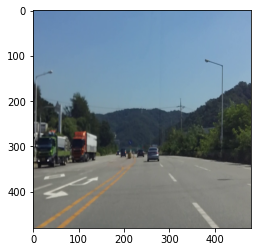

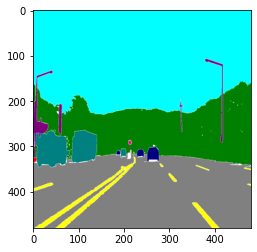

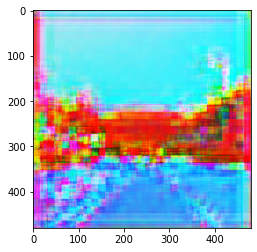

In [ ]:

"""
new_image = Image.open(validation_images[i])
new_image = new_image.resize((240,240))
plt.imshow(new_image) # This shows the image without opening a new tab to view it in.
plt.show()


new_label = Image.open(validation_labels[i])
new_label = new_label.resize((240,240))
plt.imshow(new_label)
plt.show()
"""

"""
#print(np.squeeze(image_training_set[i], 0))
plt.imshow(image_training_set[i])
plt.show()

#print(np.squeeze(mask_training_set[i], 0))
plt.imshow(mask_training_set[i])
plt.show()
"""
# This will be used to print the same image and label to be compared with our model predictions. The numbers printed are random
i = random.randint(0,len(image_array))


# This will print the actual image, the actual label, and the predicted label.
plt.imshow(image_array[i])
plt.show()

#new_label = Image.open(label_array[i])
plt.imshow(label_array[i])
plt.show()


plt.imshow(validation_predictions[i])
plt.show()

# I know this is very bad segmentation but at least it prints something right?

In [ ]:
# This will calculate the mean IoU of the actual labels and our predicted labels. 
# This is the mean IoU scores only for the training set. 
save_mean = 0
save_all_iou_scores = []
for i in range(0,len(label_array),1):
  intersection = np.logical_and(label_array[i], validation_predictions[i])
  union = np.logical_or(label_array[i], validation_predictions[i])
  iou_scores = np.sum(intersection) / np.sum(union)
  save_all_iou_scores.append(iou_scores)

for i in range(0,len(save_all_iou_scores),1):
  save_mean += save_all_iou_scores[i]

mean_iou = save_mean / len(save_all_iou_scores)
print("The mean IoU score for training set is:", mean_iou)

The mean IoU score for training set is: 0.6983194283693417


In [ ]:
############################# Everything below will be reading in the test images from the HighwayDriving File #########################################

In [ ]:
# We will create our own variables for teh TestSeq## in the directory which will be used to join to create a full path to the image
dictionary_testing = {} # Stores our new variables
for i in range(0,5,1): # Will get the 5 of the testing sequence
  dictionary_testing["string0{0}".format(i)]="TestSeq0{0}".format(i)

dictionary_testing

{'string00': 'TestSeq00',
 'string01': 'TestSeq01',
 'string02': 'TestSeq02',
 'string03': 'TestSeq03',
 'string04': 'TestSeq04'}

In [ ]:
# Checks to see if all the TestSeq## are printed in the correct format
for i in range (0,len(dictionary_testing),1):
  test_values = list(dictionary_testing.values())[i]
  print(test_values)

TestSeq00
TestSeq01
TestSeq02
TestSeq03
TestSeq04


In [ ]:
# Get all file names for the images and the labels and saves it it in a list
save_test_directory = []
test_image_path = "/content/gdrive/My Drive/Colab Notebooks/CSCI 4931/PA 3/HighwayDriving1/Test/" 
test_label_path = "/content/gdrive/My Drive/Colab Notebooks/CSCI 4931/PA 3/HighwayDriving1/Test/" 
test_image_directories = os.listdir(test_image_path)
sort_test_files = sorted(test_image_directories)
print(sort_test_files)

for directory in sort_test_files:
  if(directory != '.DS_Store'):
    save_test_directory.append(directory)


['TestSeq00', 'TestSeq01', 'TestSeq02', 'TestSeq03', 'TestSeq04']


In [ ]:
test_image_join_path = "/image"
test_label_join_path = "/label"
save_test_modified_image_path = []
save_test_modified_label_path = []
for i in range(len(save_test_directory)):
  save_test_modified_image_path.append(save_test_directory[i] + test_image_join_path)
  save_test_modified_label_path.append(save_test_directory[i] + test_label_join_path)
print(save_test_modified_image_path)

['TestSeq00/image', 'TestSeq01/image', 'TestSeq02/image', 'TestSeq03/image', 'TestSeq04/image']


In [ ]:
# Get all file names for the images and the labels and saves it it in a list
save_test_image_filenames = []
save_test_label_filenames = []
for i in range (0,len(dictionary_testing),1):
  test_values = list(dictionary_testing.values())[i]
  test_image_path = "/content/gdrive/My Drive/Colab Notebooks/CSCI 4931/PA 3/HighwayDriving/Test/" + test_values + "/image"
  test_label_path = "/content/gdrive/My Drive/Colab Notebooks/CSCI 4931/PA 3/HighwayDriving/Test/" + test_values + "/label"
  test_image_directories = os.listdir(test_image_path)
  test_label_directories = os.listdir(test_label_path)
  sort_test_image_files = sorted(test_image_directories)
  sort_test_label_files = sorted(test_label_directories)
# Print all the files and directory in the path.
  for image_file in sort_test_image_files:
    save_test_image_filenames.append(image_file)
    #print(image_file)
  for label_file in sort_test_label_files:
    save_test_label_filenames.append(label_file)

In [ ]:
# Makes sures the amount of image paths is the same as the label paths.
print(len(save_test_image_filenames))
print(len(save_test_label_filenames))

300
300


In [ ]:
# Making sure the save_test_image file contains all image filenames and all save_test_labels is the labels
# Also ensures that the images and the labels matches with each other.
for i in range(0,120,1):
  print(save_test_image_filenames[i], "\t\t", save_test_label_filenames[i])


TestSeq00_RGB_Image_0000.png 		 TestSeq00_ColorLabel_0000.png
TestSeq00_RGB_Image_0001.png 		 TestSeq00_ColorLabel_0001.png
TestSeq00_RGB_Image_0002.png 		 TestSeq00_ColorLabel_0002.png
TestSeq00_RGB_Image_0003.png 		 TestSeq00_ColorLabel_0003.png
TestSeq00_RGB_Image_0004.png 		 TestSeq00_ColorLabel_0004.png
TestSeq00_RGB_Image_0005.png 		 TestSeq00_ColorLabel_0005.png
TestSeq00_RGB_Image_0006.png 		 TestSeq00_ColorLabel_0006.png
TestSeq00_RGB_Image_0007.png 		 TestSeq00_ColorLabel_0007.png
TestSeq00_RGB_Image_0008.png 		 TestSeq00_ColorLabel_0008.png
TestSeq00_RGB_Image_0009.png 		 TestSeq00_ColorLabel_0009.png
TestSeq00_RGB_Image_0010.png 		 TestSeq00_ColorLabel_0010.png
TestSeq00_RGB_Image_0011.png 		 TestSeq00_ColorLabel_0011.png
TestSeq00_RGB_Image_0012.png 		 TestSeq00_ColorLabel_0012.png
TestSeq00_RGB_Image_0013.png 		 TestSeq00_ColorLabel_0013.png
TestSeq00_RGB_Image_0014.png 		 TestSeq00_ColorLabel_0014.png
TestSeq00_RGB_Image_0015.png 		 TestSeq00_ColorLabel_0015.png
TestSeq0

In [ ]:
# Tests to make sure that the os.path.join works as intended when creating a full path.
print(os.path.join(save_test_modified_image_path[0],save_test_image_filenames[0]))

TestSeq00/image/TestSeq00_RGB_Image_0000.png


In [ ]:
# This will iterate through all the images and labels and join the seperate paths together.
# This will be used to open the images in the test set and convert all the images and labels into numpy arrays.
# We will then predict on the numpy array of images and get our predicted mask.
current_test_image_path = []
current_test_label_path = []
track = -1
for i in range(0,5,1):
  for j in range(0,60,1):
    track = track + 1
    #print(track)
    current_test_image_path.append(os.path.join(save_test_modified_image_path[i],save_test_image_filenames[track]))
    current_test_label_path.append(os.path.join(save_test_modified_label_path[i],save_test_label_filenames[track]))
    if(track == 899):
      break

print(len(current_test_image_path))
print(len(current_test_label_path))

300
300


In [ ]:
# Create a pandas dataframe for our test image and test labels filenames
test_files_dataframe = pd.DataFrame()
test_files_dataframe['test_images'] = current_test_image_path
test_files_dataframe['test_labels'] = current_test_label_path
test_files_dataframe

,test_images,test_labels
0,TestSeq00/image/TestSeq00_RGB_Image_0000.png,TestSeq00/label/TestSeq00_ColorLabel_0000.png
1,TestSeq00/image/TestSeq00_RGB_Image_0001.png,TestSeq00/label/TestSeq00_ColorLabel_0001.png
2,TestSeq00/image/TestSeq00_RGB_Image_0002.png,TestSeq00/label/TestSeq00_ColorLabel_0002.png
3,TestSeq00/image/TestSeq00_RGB_Image_0003.png,TestSeq00/label/TestSeq00_ColorLabel_0003.png
4,TestSeq00/image/TestSeq00_RGB_Image_0004.png,TestSeq00/label/TestSeq00_ColorLabel_0004.png
...,...,...
295,TestSeq04/image/TestSeq04_RGB_Image_0055.png,TestSeq04/label/TestSeq04_ColorLabel_0055.png
296,TestSeq04/image/TestSeq04_RGB_Image_0056.png,TestSeq04/label/TestSeq04_ColorLabel_0056.png
297,TestSeq04/image/TestSeq04_RGB_Image_0057.png,TestSeq04/label/TestSeq04_ColorLabel_0057.png
298,TestSeq04/image/TestSeq04_RGB_Image_0058.png,TestSeq04/label/TestSeq04_ColorLabel_0058.png


In [ ]:
# We will iterate and join all of the seperated paths into one fill path. This will have full paths to all images and labels in the test set.
get_full_test_image_path = []
get_full_test_label_path = []
testing_path = "/content/gdrive/My Drive/Colab Notebooks/CSCI 4931/PA 3/HighwayDriving/Test/"
track = -1
for i in range(0,5,1):
  for j in range(0,60,1):
    track = track + 1
    #print(track)
    get_full_test_image_path.append(os.path.join(testing_path,save_test_modified_image_path[i],save_test_image_filenames[track]))
    get_full_test_label_path.append(os.path.join(testing_path,save_test_modified_label_path[i],save_test_label_filenames[track]))
    if(track == 899):
      break

# Prints to make sure that we have the same number of images and labels. 
# Prints to make sure that we have printed the correct full path
print(len(get_full_test_image_path))
print(len(get_full_test_label_path))
print(get_full_test_image_path[0])
print(get_full_test_label_path[0])

300
300
/content/gdrive/My Drive/Colab Notebooks/CSCI 4931/PA 3/HighwayDriving/Test/TestSeq00/image/TestSeq00_RGB_Image_0000.png
/content/gdrive/My Drive/Colab Notebooks/CSCI 4931/PA 3/HighwayDriving/Test/TestSeq00/label/TestSeq00_ColorLabel_0000.png


In [ ]:
# We will change the images into numpy arrays after we converted the image into our ideal image size for predictions.
test_image_array = []
test_label_array = []
for i in range(0,len(get_full_test_image_path),1):
  test_image = Image.open(get_full_test_image_path[i])
  test_resized_image = test_image.resize(ideal_image_size)
  test_numpy_image = asarray(test_resized_image)
  test_image_array.append(test_numpy_image)

  test_label = Image.open(get_full_test_label_path[i])
  test_resized_label = test_label.resize(ideal_image_size)
  test_numpy_label = asarray(test_resized_label)
  test_label_array.append(test_numpy_label)
  
# Prints to make sure that we have the image in numpy array, and it is the shape we want the image to be in
print(type(test_image_array[0]))
print(test_image_array[0].size)
print(test_image_array[0].shape)
print()
print(type(test_label_array[0]))
print(test_label_array[0].size)
print(test_label_array[0].shape)

<class 'numpy.ndarray'>
691200
(480, 480, 3)

<class 'numpy.ndarray'>
691200
(480, 480, 3)


In [ ]:
# We are reshaping the entire list to be (480,480,3)
test_image_array = np.array((test_image_array)).reshape(-1,ideal_width,ideal_height,3)
test_label_array = np.array((test_label_array)).reshape(-1,ideal_width,ideal_height,3)
# We are printing to ensure it is in the shape we want it in. The image and label array must be identical.
print(test_image_array.shape)
print(test_label_array.shape)

(300, 480, 480, 3)
(300, 480, 480, 3)


RGB


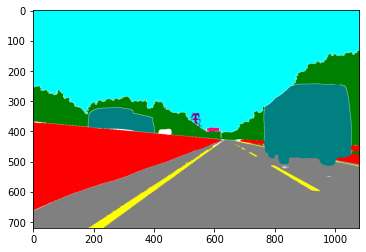

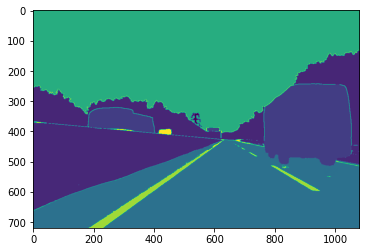

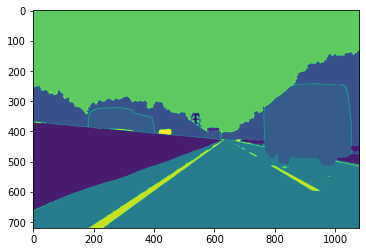

In [ ]:
# Test to see how the image looks in grayscale versus RGB.
# I have tested different ways to change the image to grayscale.
# The reason for this is because it takes less memory when the images are in grayscale versus RGB.
import matplotlib.image as mpimg
img = Image.open(get_full_test_label_path[0])
print(img.mode)
plt.imshow(img)
plt.show()
gray = img.convert('L')
gray.mode
plt.imshow(gray)
plt.show()

from skimage import io
gray1 = io.imread(get_full_test_label_path[0], as_gray=True)
plt.imshow(gray1)
plt.show()

In [ ]:
# We will use our test set images and feed it into our model and our model will predict the label of that image.
predict_test_labels = model.predict(test_image_array)

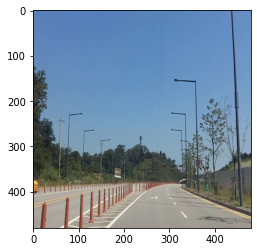

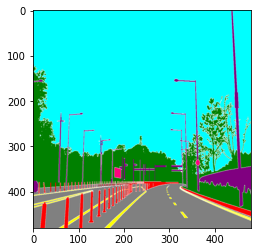

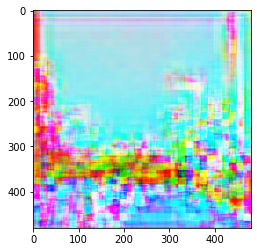

In [ ]:
# Picked a random number to display the actual image, actual label, and predicted label for comparison.

i = random.randint(0,len(test_image_array))

plt.imshow(test_image_array[i])
plt.show()

plt.imshow(test_label_array[i])
plt.show()

plt.imshow(predict_test_labels[i])
plt.show()



In [ ]:
# This will calculate the mean IoU of the actual labels and our predicted labels. 
# This is the mean IoU scores only for the testing set. 
save_test_mean = 0
save_all_test_iou_scores = []
for i in range(0,len(test_label_array),1):
  intersection = np.logical_and(test_label_array[i], predict_test_labels[i])
  union = np.logical_or(test_label_array[i], predict_test_labels[i])
  iou_scores = np.sum(intersection) / np.sum(union)
  save_all_iou_scores.append(iou_scores)

for i in range(0,len(save_all_test_iou_scores),1):
  save_test_mean += save_all_test_iou_scores[i]

test_mean_iou = save_mean / len(save_all_iou_scores)
print("The mean IoU score for testing set is:", test_mean_iou)

The mean IoU score for testing set is: 0.5237395712770062


In [ ]:
# Print the comparison of the mean IoU of training set and testing set.
# This is not going to be very high. But at least it is something.
print("The mean IoU score for training set is:", mean_iou)
print("The mean IoU score for testing set is:", test_mean_iou)

The mean IoU score for training set is: 0.6983194283693417
The mean IoU score for testing set is: 0.5237395712770062
